# Tuning Book for NREL 5MW Turbine

### Introduction notes

In [1]:
# This book presents an example of tuning a FLORIS model to SOWFA data of a turbine operating in various conditions
# For information about the provided data sets see the also provided noteboooks:
#   reviewPowerData.ipynb
#   showWakeProfilesFromSOWFA.ipynb

In [2]:
# Basic module imports
%matplotlib inline
import os
import time
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import cPickle as pickle
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [3]:
# Imports from openmdao
from openmdao.api import Problem, Group, IndepVarComp
from pyoptsparse import Optimization, OPT, SNOPT


In [4]:
# Imports from FLORIS
from florisse.floris import DirectionGroup
from florisse import config

In [5]:
# Load the SOWFA data sets
yawPos,avPowersYaw, yawPosI2,avPowersYawI2 = pickle.load( open( os.path.join('data','yawPower.p'), "rb" ) )
spacing,avPowersSpace = pickle.load( open( os.path.join('data','spacePower.p'), "rb" ) )
offset4D,avPowersOffset4D = pickle.load( open( os.path.join('data','offset4DPower.p'), "rb" ) )
offset6D,avPowersOffset6D = pickle.load( open( os.path.join('data','offset6DPower.p'), "rb" ) )

### Initial FLORIS Settings

In [6]:
# These initial settings are taken from 
# Gebraad, P. M. O., Teeuwisse, F. W., van Wingerden, J. W., Fleming, P. a., Ruben, S. D., Marden, J. R., & Pao, L. Y. (2014). Wind plant power optimization through yaw control using a parametric model 
#    for wake effects-a CFD simulation study. Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1822
# Which were arrived at through manual tuning and adjustment to SOWFA data selected from
# Fleming, P. A., Gebraad, P. M. O., Lee, S., van Wingerden, J.-W., Johnson, K. E., Churchfield, M., … Moriarty, P. J. (2014). Simulation comparison of wake mitigation control strategies for a two-turbine case. 
#    Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1810

In [7]:
# These first set of parameters set certain behaviors of the FLORIS model
# Note that we would like to make smooth + rotor THE FLORIS model very soon

model = 'smooth'  # options: 'original', 'smooth'
gradients = 'fd'    # options: 'fd', 'exact'
flat = True        # if False, will use cosine smoothing factor
rotor = True       # if True, will use rotor coupled data
tune = False        # if True, will optimize parameters starting with provided values

if model == 'smooth':
    differentiable = True
else:
    differentiable = False


### NREL 5MW direct settings

In [8]:
# Certain components of the model are fixed properties of the turbine used which can be derived/computed
# directly from FAST

In [9]:
# Set properties of the turbine
rotorDiameter = 126.0
generatorEfficiency = 0.944

In [10]:
# The Ct/Cp table is an important component of the turbine model
# NOTE ANOTHER SHEET GIVES AN EXAMPLE ON HOW THIS CAN BE DERIVED FROM FAST
# VERY IMPORTANT TO NOTE: CP/CT should include ALL efficency losses EXCEPT generator efficiency

# Load the Cp table for NREL 5MW
NREL5MWCPCT = pickle.load(open('../NREL5MWCPCT_smooth_dict.p'))
datasize = NREL5MWCPCT['CP'].size
# These are arrays of CP and CT versus wind speed
NREL5MWCPCT

{'CP': array([ 0.        ,  0.15643578,  0.31287155,  0.41306749,  0.44895632,
         0.46155227,  0.46330747,  0.46316077,  0.46316077,  0.46280642,
         0.45223111,  0.39353012,  0.3424487 ,  0.2979978 ,  0.25931677,
         0.22565665,  0.19636572,  0.17087684,  0.1486965 ,  0.12939524,
         0.11259934,  0.0979836 ,  0.08526502,  0.07419736,  0.06456631,
         0.05618541,  0.04889237,  0.        ]),
 'CT': array([ 1.10610965,  1.09515807,  1.0227122 ,  0.9196487 ,  0.8519047 ,
         0.80328229,  0.76675469,  0.76209299,  0.76209299,  0.75083241,
         0.67210674,  0.52188504,  0.43178758,  0.36443258,  0.31049874,
         0.26696686,  0.22986909,  0.19961578,  0.17286245,  0.15081457,
         0.13146666,  0.11475968,  0.10129584,  0.0880188 ,  0.07746819,
         0.06878621,  0.05977061,  0.        ]),
 'wind_speed': array([  0.        ,   2.5       ,   3.52338654,   4.57015961,
          5.61693268,   6.66370575,   7.71047882,   8.75725189,
          9.804024

### Other model parameters

In [11]:
# Describe this more later

In [12]:
## Set models for FLORIS parameters
# These are the simulation parameters specific to a given turbine / enviornment

# power
pP = 1.88   # control Cp adjustment to yaw

# deflection
kd = 0.15                       # adjust yaw deflection
# global initialWakeDisplacement
initialWakeDisplacement = -4.5  # initial rotational displacement
bd = -0.01                      # continued deflection from rotation as separation increases
# initialWakeAngle = 0.5*3.0
initialWakeAngle = 1.5

# expansion
ke = 0.065                          # adjust overall rate of wake expansion
# global me
me = np.array([-0.5, 0.22, 1.0])    # adjust individual wake expansion

# velocity
#global MU
MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate

aU = 5.0                            # offset in decay adjustment
bU = 1.66                           # parameter of yaw on decay adjustment
cos_spread = 1e12                   # additional deficit based on crosswind relative location

if rotor:
    # deflection
    kd = 0.17                   # adjust yaw deflection

    # expansion
    ke = 0.05                   # adjust overall rate of wake expansion

    # velocity
    aU = 12.                    # offset in decay adjustment
    bU = 1.3                    # parameter of yaw on decay adjustment

if not flat:
    # velocity
    cos_spread = 2.0                    # additional deficit based on crosswind relative location
    MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate
    me = np.array([-0.5, 0.3, 1.0])    # adjust individual wake expansion
    initialWakeAngle = 1.5

In [13]:
### Inflow parameters

In [14]:
# Inflow conditions

air_density = 1.1716 
wind_direction = 270.-0.523599*180./np.pi 


In [48]:
# Wind speed should be determined, assuming the the turbine is the observer of wind speed and work backward from power
# through generator efficiency and Cp to determine the speed for a case where the turbine operates non-yawed

## JARED CAN YOU PROPOSE SOMETHING NICER?

sowfaRefPower = avPowersYaw[3,0]
rotorArea = np.pi * (rotorDiameter/2.)**2
#rot
Cp_Interp = interp1d( NREL5MWCPCT['wind_speed'],  NREL5MWCPCT['CP'])
def powerError(ws): 
    Cp = Cp_Interp(ws)
    estPower =   generatorEfficiency*(0.5*air_density*rotorArea*Cp*np.power(ws, 3))
    return abs(sowfaRefPower - estPower)


## Just not too familiar with these tools...
#res = minimize(powerError,8.0,bounds=[(4,20)])#,method='SLSQP')
#print res

# Doing it by hand...
wind_speed = 8.485
powerError(wind_speed)


1197.3537863206584

### Build the FLORIS model

In [ ]:
# In first scenarios, we will use a two turbine setup

In [49]:
nTurbines = 2

In [50]:
# Definte the FLORIS model within openmdao

global prob
prob = Problem(root=Group())
# Add a FLORIS model
prob.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])
# set up problem
prob.setup(check=False)

{}

In [52]:
# Add Cp-Ct information
if rotor:
    prob['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    prob['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    prob['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    prob['floris_params:useWakeAngle'] = True
    prob['floris_params:adjustInitialWakeDiamToYaw'] = False
    prob['floris_params:axialIndProvided'] = False
    prob['floris_params:useaUbU'] = True

In [53]:
# Assign all neccessary FLORIS parameters
prob['gen_params:pP'] = pP
prob['floris_params:kd'] = kd
prob['floris_params:initialWakeAngle'] = initialWakeAngle
prob['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
prob['floris_params:bd'] = bd
prob['floris_params:ke'] = ke
prob['floris_params:me'] = me
prob['floris_params:MU'] = MU
prob['floris_params:aU'] = aU
prob['floris_params:bU'] = bU
prob['floris_params:cos_spread'] = cos_spread
prob['rotorDiameter'] =  np.array([rotorDiameter for i in range(nTurbines)])
prob['axialInduction'] = np.zeros(nTurbines) ## Not needed?
prob['generatorEfficiency'] = np.array([generatorEfficiency for i in range(nTurbines)])
prob['yaw0'] = np.zeros(nTurbines)
prob['wind_speed'] = wind_speed
prob['air_density'] = air_density
prob['wind_direction'] = wind_direction

### Define a comparison plotting function

In [56]:
# Define a power comparison plotting function
def ComparePower(xPoints,sowfaPower,FLORISpower,xlabel=''):

    fig, axarr = plt.subplots(3,2,figsize=(10,8),sharex=True)

    # Plot turbine 0
    ax = axarr[0,0]
    ax.plot(xPoints,sowfaPower[:,0]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,0],'o-',label='FLORIS')
    ax.set_title('Turbine 0')
    ax.legend()

    ax = axarr[0,1]
    ax.plot(xPoints,100 * (FLORISpower[:,0] - sowfaPower[:,0]/1000.)/(sowfaPower[:,0]/1000.),'x--',label='SOWFA')
    ax.set_title('Turbine 0 % Error')

    # Plot turbine 1
    ax = axarr[1,0]
    ax.plot(xPoints,sowfaPower[:,1]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,1],'o-',label='FLORIS')
    ax.set_title('Turbine 1')
    ax.legend()

    ax = axarr[1,1]
    ax.plot(xPoints,100 * (FLORISpower[:,1] - sowfaPower[:,1]/1000.)/(sowfaPower[:,1]/1000.),'x--',label='SOWFA')
    ax.set_title('Turbine 1 % Error')

    # Plot total power
    ax = axarr[2,0]
    totalSOWFA = np.sum(sowfaPower,axis=1)
    totalFLORIS = np.sum(FLORISpower,axis=1)
    ax.plot(xPoints,totalSOWFA/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,totalFLORIS,'o-',label='FLORIS')
    ax.set_title('Total')
    ax.set_xlabel(xlabel)
    ax.legend()

    ax = axarr[2,1]
    ax.plot(xPoints,100 * (totalFLORIS - totalSOWFA/1000.)/(totalSOWFA/1000.),'x--',label='SOWFA')
    ax.set_title('Total % Error')
    ax.set_xlabel(xlabel)

### Compare to 4D yaw powers

In [54]:
# Set the turbine positions
prob['turbineX'] = np.array([1118.1, 1556.0])
prob['turbineY'] = np.array([1279.5, 1532.3])
FLORISpower = list()
for yaw1 in yawPos:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

/home/pfleming/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


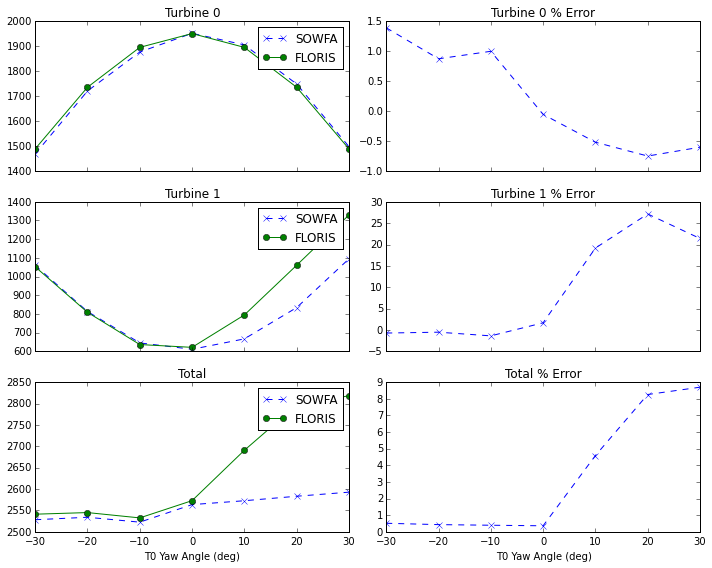

In [57]:
# Compare the power for this case
ComparePower(yawPos,avPowersYaw,FLORISpower,'T0 Yaw Angle (deg)')

### Compare spacing power

In [58]:
# Compare the powers as the downstream turbine is located at various spacings

In [59]:
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1337.0,1556.0,1774.9,1993.8,2212.7]
turb1_y = [1405.9,1532.3,1658.7,1785.1,1911.5]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(spacing)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

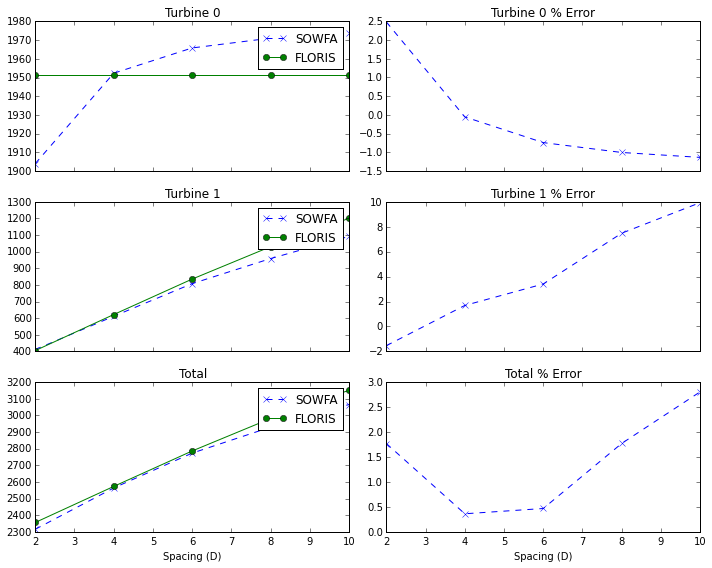

In [60]:
# Compare the power for this case
ComparePower(spacing,avPowersSpace,FLORISpower,'Spacing (D)')

### Compare crosswind locations (4D)

In [61]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1526.0,1541.0,1556.0,1571.0,1586.0]
turb1_y = [1584.3,1558.3,1532.3,1506.3,1480.3]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(offset4D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

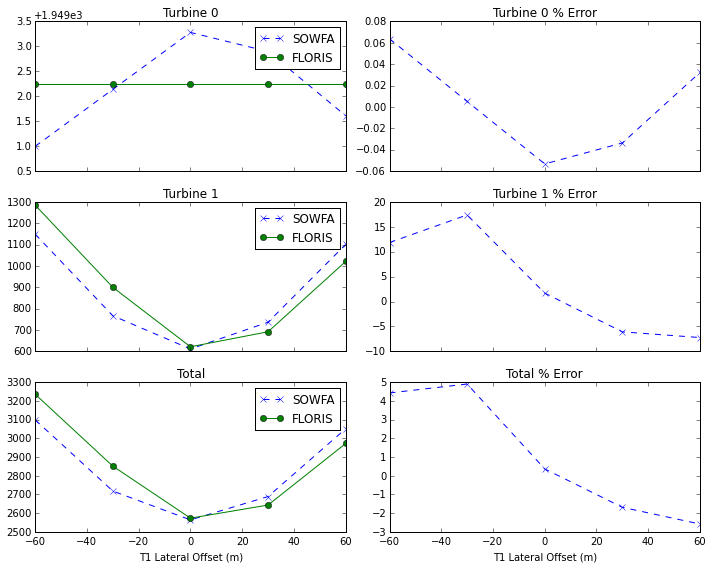

In [62]:
# Compare the power for this case
ComparePower(offset4D,avPowersOffset4D,FLORISpower,'T1 Lateral Offset (m)')

### Compare crosswind locations (6D)

In [63]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1744.9,1759.9,1774.9,1789.9,1804.9]
turb1_y = [1710.7,1684.7,1658.7,1632.7,1606.7]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(offset6D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

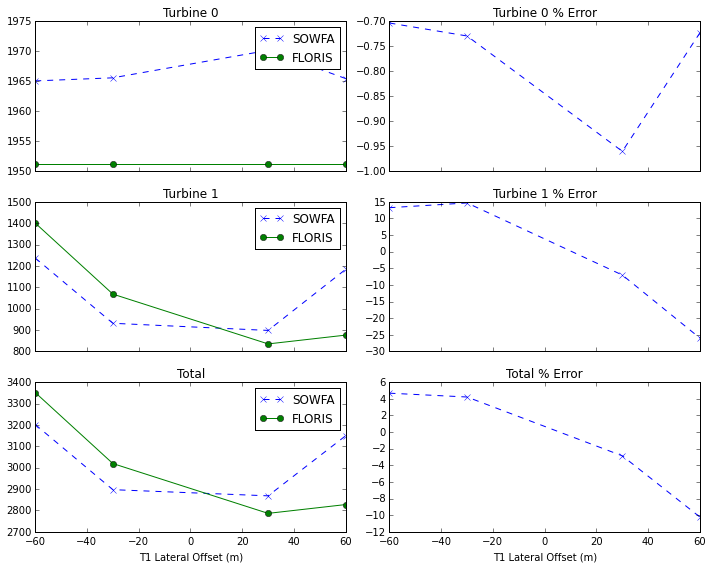

In [64]:
# Compare the power for this case
ComparePower(offset6D,avPowersOffset6D,FLORISpower,'T1 Lateral Offset (m)')

## Compare 1 Turbine wake profiles

In [72]:
# Also available are downwind profiles from a single turbine simulation in SOWFA

In [65]:
# NOTE SAMPLING IS DONE HERE USING A SECOND TURBINE SWEPT ACROSS LOCATIONS
# THE ADVANTAGE IS THAT THE TURBINE SAMPLES A SPACE LARGER THAN A SINGLE POTNI AND PRODUCES AN EFFECTIVE
# WIND SPEED AT EACH POINT INCLUDING WAKE OVERLAPS

In [66]:
# Load the downwind profiles
downStreamLocs,ySampling,caseNames,wakeProfiles = pickle.load( open( os.path.join('data','wakeProfiles.p'), "rb" ) )

In [71]:
# Identify local variables
yawAngles = caseNames #angle of turbine in deg
numYaw = len(yawAngles)
numDownStreamLocs = len(downStreamLocs)
numSamples = len(ySampling)

# ySampling gives (in D) a lateral offset from a given downstream location, need to convert this actual FLORIS positons
# assume for now initial turbine at 0, and downwind along x axis


In [ ]:
## TODO MAYBE ITS NEATER TO COPY PROB TO A NEW PROBLEM TO AVOID BACK AND FORTH ERRORS

In [72]:
# Let's redo prob for 1-turbine case
# Inflow conditions
wind_direction = 270 # Lets go right down x for this case
prob['wind_direction'] = wind_direction

In [73]:
# Put a signle turbine at 0
turb0_x = 0.0
turb0_y = 0.0

In [83]:
wakeProfiles

[[array([ 7.79906772,  7.79599648,  7.79599648,  7.78678665,  7.80304126,
          7.81023912,  7.81023912,  7.84407689,  7.88403389,  7.86164076,
          7.86275463,  7.83981429,  7.86089377,  7.8794767 ,  7.89041219,
          7.86943556,  7.88211505,  7.9314131 ,  7.97515667,  7.97706623,
          7.95982466,  7.93993207,  7.9527352 ,  8.00851246,  8.01741936,
          8.01036607,  8.04002538,  8.07087233,  8.08310413,  8.09919615,
          8.16316758,  8.15237224,  8.17525524,  8.17649233,  8.18484876,
          8.18642256,  8.19428011,  8.19665679,  8.22759546,  8.24088337,
          8.24354169,  8.4217446 ,  8.27793179,  7.22504346,  5.97247451,
          4.64156144,  4.28973645,  4.56806029,  5.63842292,  6.31089205,
          6.52452537,  6.4012928 ,  6.11718601,  5.78793964,  5.61161079,
          5.33969235,  5.09132015,  5.0509997 ,  5.79954412,  7.51978661,
          8.10257194,  8.20980031,  8.18071151,  8.19253283,  8.17057714,
          8.17898566,  8.17143066,  8.

In [79]:
# Now run a loop to probe
florisSample = np.zeros((numSamples,numDownStreamLocs))
for s in range(numSamples):
    for d in range(numDownStreamLocs):
        prob['turbineX'] = np.array([turb0_x, downStreamLocs[d] * rotorDiameter])
        prob['turbineY'] = np.array([turb0_y, ySampling[s]])
        prob.run()
        florisSample[s,d] = prob['wtVelocity0'][1]

In [80]:
# Compare the profiles
fig, axarr = plt.subplots(numSamples)

array([[ 4.62373241,  5.05520006,  5.44327742,  5.79186778,  6.10443497,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.62490604,  5.05629538,  5.44421423,  5.7925803 ,  6.10487043,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.62608492,  5.05739483,  5.44515724,  5.79330196,  6.10532146,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.62726877,  5.05849826,  5.44610627,  5.79403241,  6.10578721,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.6284573 ,  5.05960552,  5.44706109,  5.79477134,  6.10626689,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.62965025,  5.06071649,  5.44802153,  5.79551843,  6.1067598 ,
         6.38583402,  6.63593465,  6.85479001,  7.04574217,  7.21195076],
       [ 4.6308474 ,  5.06183103,  5.44898739,  5.79627341,  6.1072653 ,
         6.38590576,  6.63593465,  6.85479001

In [ ]:
# Plot the wake profiles

# Derive data
numCase = len(caseNames)

# Set up plot and colors
colorIndex = np.linspace(0.,1.,numCase)
colors = plt.cm.coolwarm(colorIndex)
fig, axarr = plt.subplots(len(downStreamLocs)/2,2,figsize=(10,10))
axarr =  axarr.flatten()


for c in range(numCase):  
    for dIdx, d in enumerate(downStreamLocs):
        axarr[dIdx].plot(ySampling,wakeProfiles[dIdx][c],label=caseNames[c],color=colors[c])
        axarr[dIdx].set_title('D = %d' % d)

axarr[0].legend(bbox_to_anchor=(0, 1.05), loc='lower left', borderaxespad=0.)

# TO DELETE

In [ ]:
# ICOWES 2 STUFF

In [59]:
prob['turbineX'] = np.array([1118.1, 1881.9])
prob['turbineY'] = np.array([1279.5, 1720.5])
FLORISpower = list()
for yaw1 in yawPosI2:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

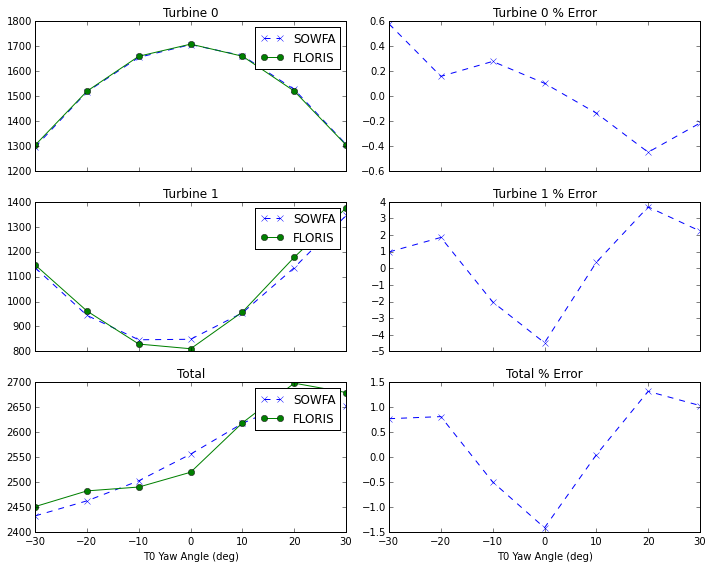

In [60]:
# Compare the power for this case
ComparePower(yawPosI2,avPowersYawI2,FLORISpower,'T0 Yaw Angle (deg)')